# **Anime Recommendation System**

### **1. Introduction**
#### Users can spend hours browsing through hundreds, sometimes thousands, of anime without finding the content they like. 
#### My goal is to create a recommendation engine that will suggest anime based on users' preferences using: 
* KMeans clustering (with hyperparameter selection)
* Singular Value Decomposition

#### The data set contains information on user preference data from 73,516 users on 12,294 anime. 
#### Each user is able to add anime to their completed list and give it a rating and this data set is a compilation of those ratings.
####  

#### **Import requirement libraries:**

In [1]:
import numpy as np
import pandas as pd
import os

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sb
from cleantext import clean

# for preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder

# SVD (Singular Value Decomposition) model
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

# clustering and dimensionality reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# evaluating the model
from sklearn.metrics import mean_squared_error

# for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# 3D plotting for visualizing clusters
from mpl_toolkits.mplot3d import Axes3D

from collections import defaultdict

### 
### **2. Step 1. Get data**

#### **Import Data**:

In [2]:
df_anime = pd.read_csv("./data/anime.csv")
df_rating = pd.read_csv("./data/rating.csv")

###  
### **3. Step 2. Exploratory Data Analysis (EDA)**

### **Information about datasets sizes:**

In [3]:
print('anime shape: ', df_anime.shape, 'rating shape: ', df_rating.shape)

anime shape:  (12294, 7) rating shape:  (7813737, 3)


#### **Conclusion**: almost 8 million ratings for about 12 thousand anime movies.
#### 

### **Columns Information:**

#### 1. Anime data:

In [4]:
print('column names: \n')

for val in df_anime.columns:
    print(val)

column names: 

anime_id
name
genre
type
episodes
rating
members


#### **anime_id** - myanimelist.net's unique id identifying an anime.
#### **name** - full name of anime.
#### **genre** - comma separated list of genres for this anime.
#### **type** - movie, TV, OVA, etc.
#### **episodes** - how many episodes in this show. (1 if movie).
#### **rating** - average rating out of 10 for this anime.
#### **members** - number of community members that are in this anime's "group".

#### 2. Rating data:

In [5]:
print('column names: \n')

for val in df_rating.columns:
    print(val)

column names: 

user_id
anime_id
rating


#### **user_id** - non identifiable randomly generated user id.
#### **anime_id** - the anime that this user has rated.
#### **rating** - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).
####  

### **Information about columns data types:**

#### 1. Anime data:

In [6]:
print('data types: \n')
print(df_anime.dtypes)

data types: 

anime_id      int64
name         object
genre        object
type         object
episodes     object
rating      float64
members       int64
dtype: object


#### 2. Rating data:

In [7]:
print('data types: \n')
print(df_rating.dtypes)

data types: 

user_id     int64
anime_id    int64
rating      int64
dtype: object


#### Features - are the input variables that are used to train the model. Features represent different aspects of the data that can help the model make predictions or decisions. 
#### Each feature is a column in the tabular data and contains values that describe observations (rows).
#### Below I will show which features in my opinion are the most important in this project:
#### **user_id**: Unique user ID. This is important for tracking which users are rating which anime.
#### **name**: The name of the anime (or its ID). This helps the model associate ratings with specific anime.
#### **rating_x**: The rating the user gave the anime. This is the target variable the model is trying to predict.
#### 

#### **Feature: rating**

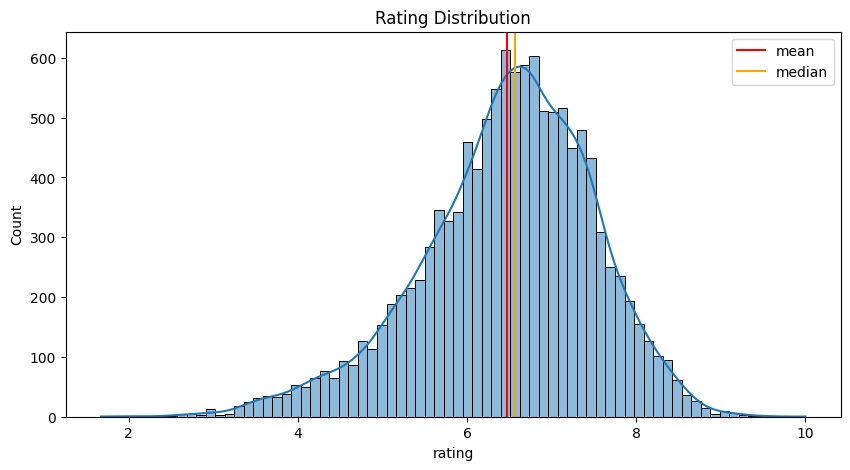

In [8]:
plt.figure(figsize=(10, 5))

sb.histplot(df_anime['rating'], kde=True)

plt.axvline(df_anime['rating'].mean(), label='mean', color='red')
plt.axvline(df_anime['rating'].median(), label='median', color='orange')

plt.title('Rating Distribution')
plt.legend()

plt.show()

#### **Feature: type** (I will not use in SVD)

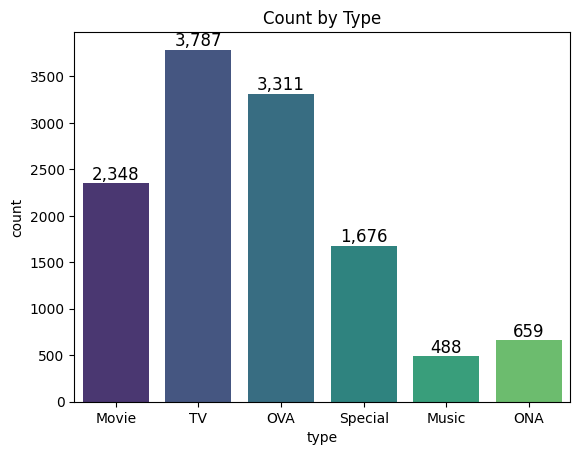

In [9]:
unique_types = df_anime['type'].unique()
palette = sb.color_palette("viridis", len(unique_types))
palette_dict = dict(zip(unique_types, palette))


plot = sb.countplot(data=df_anime, x='type', hue='type', palette=palette_dict, legend=False)

plot.set_title('Count by Type')

for p in plot.patches:
    count = p.get_height()
    plot.annotate(f'{count:,.0f}', (p.get_x() + p.get_width() / 2., count),
                  ha='center', va='bottom', color='black', fontsize=12)

plt.show()


#### **Rating by type:**

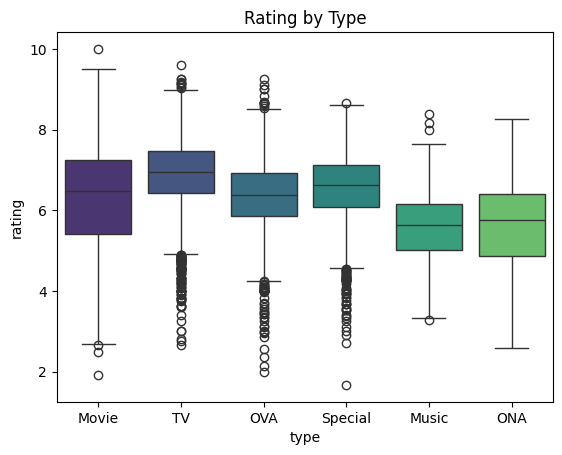

In [10]:
plot = sb.boxplot(data=df_anime, x='type', y='rating', hue='type', palette=palette_dict, legend=False, dodge=False)
plot.set_title('Rating by Type')
plt.show()

#### **Genre:**

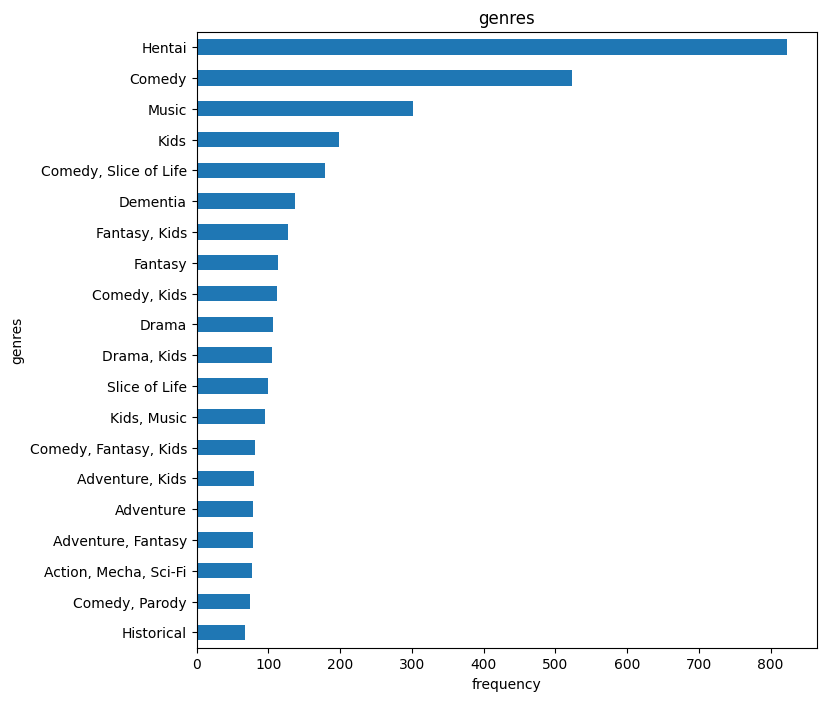

In [11]:
df_anime['genre'].value_counts().sort_values(ascending=True).tail(20).plot.barh(figsize=(8,8))
plt.title('genres')
plt.xlabel('frequency')
plt.ylabel('genres')
plt.show()

#### **Data transformation:**

#### 1. I should transform number of episodes datatype to float and replace Unknown to nan:

In [12]:
df_anime['episodes']=df_anime['episodes'].replace('Unknown',np.nan)
df_anime['episodes']=df_anime['episodes'].astype(float)

#### 2. I should clean **name** feature 

In [13]:
def clean_text(text):
    text = clean(text,
                 lower=True,  # Convert to lowercase
                 no_urls=True,  # Remove URLs
                 no_emails=True,  # Remove emails
                 no_phone_numbers=True,  # Remove phone numbers
                 no_numbers=True,  # Remove numbers
                 no_digits=True,  # Remove digits
                 no_punct=True,  # Remove punctuation
                 replace_with_url="<url>",  # Replace URL with a placeholder
                 replace_with_email="<email>",  # Replace email with a placeholder
                 replace_with_phone_number="<phone_number>",  # Replace phone number with a placeholder
                 )
    return text


In [14]:
df_anime['name'] = df_anime['name'].apply(clean_text)

###  
### **Check Missing Values**

#### 1. Anime data:

In [15]:
df_anime.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes    340
rating      230
members       0
dtype: int64

#### 2. Rating data:

In [16]:
df_rating.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

#### **Conclusion**: I should clean Anime data frame from missing values

###  
### **Check Duplicates**

#### 1. Anime data:

In [17]:
print('duplicated anime: ', df_anime[df_anime.duplicated()].shape[0])

duplicated anime:  0


#### 2. Rating data:

In [18]:
print('duplicated ratings: ', df_rating[df_rating.duplicated()].shape[0])

duplicated ratings:  1


#### **Conclusion**: we should clean Rating data frame from duplicated value

###  
### **Data cleaning**

#### **Remove Missing Rows**

In [19]:
df_anime.dropna(axis = 0, inplace = True)
df_anime.isna().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

In [20]:
print('number of rows after removing missing rows: ', df_anime.shape[0])

number of rows after removing missing rows:  11830


#### **Remove duplicates**

In [21]:
df_rating.drop_duplicates(keep='first',inplace=True)

print('duplicated ratings after removing: ', df_rating[df_rating.duplicated()].shape[0])

duplicated ratings after removing:  0


###  
## **4. Building a model**

##### Create a new dataset by merging 2 datasets:

In [22]:
data = pd.merge(df_anime, df_rating, on="anime_id")


In [23]:
data = data.drop('rating_y', axis=1)
data.tail()

,anime_id,name,genre,type,episodes,rating_x,members,user_id
7813601,6133,violence gekiga shin david no hoshi inma densetsu,Hentai,OVA,1.0,4.98,175,39532
7813602,6133,violence gekiga shin david no hoshi inma densetsu,Hentai,OVA,1.0,4.98,175,48766
7813603,6133,violence gekiga shin david no hoshi inma densetsu,Hentai,OVA,1.0,4.98,175,60365
7813604,26081,yasuji no pornorama yacchimae,Hentai,Movie,1.0,5.46,142,27364
7813605,26081,yasuji no pornorama yacchimae,Hentai,Movie,1.0,5.46,142,48766


####  
#### user rating (rating_x) can be -1 if the user watched it but didn't assign a rating. lets replace it with **NAN** value. and delete duplicate values:

In [24]:
data["rating_x"] = data["rating_x"].replace(to_replace = -1, value = np.nan)
data = data.dropna(axis = 0)

In [25]:
data.isna().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating_x    0
members     0
user_id     0
dtype: int64

In [26]:
print('duplicated values in new dataset: ', df_anime[df_anime.duplicated()].shape[0])

duplicated values in new dataset:  0


## **SVD Model**

In [27]:
# Create a Reader object specifying the rating scale
reader = Reader(rating_scale=(1, 10))

# Load the data into a Surprise dataset format
svd_data = Dataset.load_from_df(data[['user_id', 'name', 'rating_x']], reader)

# Split the dataset into a training set and a test set
train_set, test_set = train_test_split(svd_data, test_size=.2)

# Initialize Singular Value Decomposition model
svd_model = SVD()

# fit model
svd_model.fit(train_set)

# test the trained model on the test set to get predictions
predictions = svd_model.test(test_set)



In [28]:
accuracy.rmse(predictions)

RMSE: 0.0769


0.07693036500340181

#### **Conclusion:** The obtained RMSE value of 0.0773 is quite low, which may indicate good quality of the model's predictions. 
#### However:
1. It can be Unrealistically low RMSE value: Such a low RMSE value may be a result of overcalibration of the model or the presence of data in the test set that is very similar to the data in the training set.
2. It may also indicate that the data is very well structured and the model easily finds patterns.
####  
####  Creating a function for anime recommendations:

In [29]:
def recommend(user_id, num_recommendations=5):
    # Get all anime names
    all_anime = data['name'].unique()

    # get animes rated by user
    rated_anime = data[data['user_id'] == user_id]['name'].tolist()

    # create predictions
    predictions = []
    for anime in all_anime:
        if anime not in rated_anime:
            prediction = svd_model.predict(user_id, anime)
            predictions.append((anime, prediction.est))

    # sort recomendations
    recommendations = sorted(predictions, key=lambda x: x[1], reverse=True)[:num_recommendations]
    
    return recommendations
    
user_id = 1
recommended_anime = recommend(user_id, num_recommendations=5)

for anime, predicted_rating in recommended_anime:
    print(f"Recommended anime: {anime}, Predicted Rating: {predicted_rating:.2f}")

Recommended anime: kimi no na wa, Predicted Rating: 9.31
Recommended anime: gintamadeg, Predicted Rating: 9.19
Recommended anime: fullmetal alchemist brotherhood, Predicted Rating: 9.15
Recommended anime: haikyuu karasuno koukou vs shiratorizawa gakuen koukou, Predicted Rating: 9.11
Recommended anime: ginga eiyuu densetsu, Predicted Rating: 9.08


####  
## **K-means clustering**

### **data preparation**

In [30]:
encoder_genre = LabelEncoder()
encoder_type = LabelEncoder()
data['t_genre'] = encoder_genre.fit_transform(data['genre'])
data['t_type'] = encoder_type.fit_transform(data['type'])

features = ['anime_id', 't_genre', 't_type', 'rating_x']

X = data[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.drop(columns='anime_id'))

n_samples, n_features = X_scaled.shape
n_components = min(n_samples, n_features)

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

### **optimization of hyperparameters**

#### For the KMeans algorithm with **algorithm='elkan'** it may be useful to use it when the number of records exceeds 100,000, 
#### as it optimizes the calculations for large data sets.
#### i have more than 7 million records, so i will not use Lloyd's Algorithm

In [31]:
# Convert the data to a DataFrame and sample 10,000 rows for training
sample_X_pca = pd.DataFrame(X_pca).sample(n=10000, random_state=42)

# Define the grid of hyperparameters for tuning
param_grid = {
    'n_clusters': [15, 20, 25], 
    'init': ['k-means++', 'random'],
    'n_init': [5, 10, 15],
    'max_iter': [50, 100, 300, 500],
    'algorithm': ['elkan']
}

# Initialize the KMeans model
kmeans = KMeans(random_state=42)

# Initialize GridSearchCV to find the best combination of hyperparameters
grid_search = GridSearchCV(estimator=kmeans, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(sample_X_pca)


best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")



C:\Users\azaza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Hyperparameters: {'algorithm': 'elkan', 'init': 'k-means++', 'max_iter': 50, 'n_clusters': 15, 'n_init': 5}


#### I will use this parameters in my model:

In [32]:
# Initialize the KMeans clustering model
kmeans = KMeans(
    n_clusters=15, 
    init='k-means++', 
    max_iter=50,
    n_init=5, 
    algorithm='elkan',
    random_state=42
)

# fit the KMeans model to the PCA-transformed data and predict
data['cluster'] = kmeans.fit_predict(X_pca)

# average rating for each cluster
cluster_avg_ratings = data.groupby('cluster')['rating_x'].mean()

# Convert the average ratings to a dictionary: clusters - average ratings
cluster_pred_ratings = cluster_avg_ratings.to_dict()

# map the predicted cluster ratings back
data['predicted_rating'] = data['cluster'].map(cluster_pred_ratings)

actual_ratings = data['rating_x'].values
predicted_ratings = data['predicted_rating'].values

rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))

print(f"RMSE: {rmse}")

RMSE: 0.293549313130055


#### The RMSE value of 0.2647 looks more realistic than the previous value of 0.0773, especially for the rating prediction task. 
#### This indicates that this model works quite well, but there is still room for improvement.
#### 
#### **Clusters:**

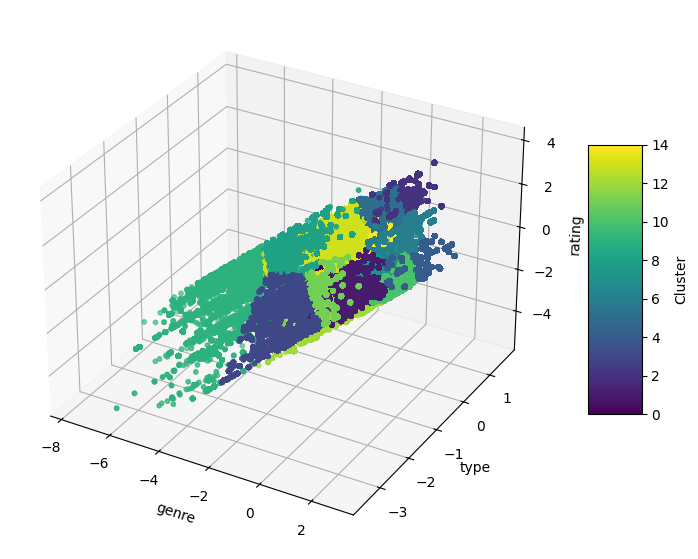

In [33]:
# first 3 principal components for 3D visualization
X_pca_3d = X_pca[:, :3]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=data['cluster'], cmap='viridis', s=10)

# add a colorbar
cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Cluster')

# labels
ax.set_xlabel('genre')
ax.set_ylabel('type')
ax.set_zlabel('rating')

plt.show()

####  Creating a function for anime recommendations:

In [34]:
def recommend(user_id, num_recommendations=5):
    all_anime = data['name'].unique()
    rated_anime = data[data['user_id'] == user_id]['name'].tolist()
    user_cluster = data[data['user_id'] == user_id]['cluster'].mode()[0]
    cluster_anime = data[data['cluster'] == user_cluster]
    predictions = []
    for anime in all_anime:
        if anime not in rated_anime:
            if anime in cluster_anime['name'].values:
                predicted_rating = cluster_pred_ratings[user_cluster]
                predictions.append((anime, predicted_rating))
    
    recommendations = sorted(predictions, key=lambda x: x[1], reverse=True)[:num_recommendations]
    
    return recommendations

user_id = 1
recommended_anime = recommend(user_id, num_recommendations=5)

for anime, predicted_rating in recommended_anime:
    print(f"Recommended anime: {anime}, Predicted Rating: {predicted_rating:.2f}")

Recommended anime: to loveru darkness 0nd, Predicted Rating: 7.39
Recommended anime: full metal panic the second raid wari to hima na sentaichou no ichinichi, Predicted Rating: 7.39
Recommended anime: majin tantei nougami neuro, Predicted Rating: 7.39
Recommended anime: master keaton, Predicted Rating: 7.39
Recommended anime: dfrag, Predicted Rating: 7.39


**Conclusion:** In this work, an anime recommendation system was developed using two machine learning methods, **Singular Value Decomposition (SVD)** and **K-Means clustering**. For SVD, a low RMSE value was obtained, indicating good prediction quality, but this could also be due to data features or model overfitting. For K-Means clustering, hyperparameter selection was performed using **GridSearchCV**, which yielded a model with a more realistic prediction error, within 0.29. The model effectively clusters anime based on genre, type, and rating, which helps in more accurate recommendations.
Recommendations to users based on their preferences and cluster analysis can predict anime that they are likely to be interested in with high accuracy. The system can be improved by further tuning the parameters and adding new factors to analyze user preferences.
Overall, the completed work demonstrates the successful application of machine learning techniques to create recommendation systems that can efficiently process large amounts of data and provide personalized recommendations.
